# 2.4 Maxwell-Gleichungen

## Physikalischer Aufbau: Magnetostatisches Feld eines Permanentmagneten <br>
Die vier Maxwell-Gleichungen: <br>
$$
\begin{array}[ll]
\text{(I)    } \nabla \cdot \mathbf{E} = \dfrac{\rho}{\varepsilon_0} & \text{(II)  }\nabla \cdot \mathbf{B} = 0 \\
\text{(III)  } \nabla \times \mathbf{E} = -\dfrac{\partial \mathbf{B}}{\partial t} &\text{(IV)  }  \nabla \times \mathbf{B} = \mu_0 \mathbf{j} + \mu_0 \varepsilon_0 \dfrac{\partial \mathbf{E}}{\partial t}
\end{array}
$$ <br>
Hierbei ist $\mathbf{E}$ die elektrische Feldstärke, $\mathbf{B}= \mu_0 \mu_r (\mathbf{M} + \mathbf{H})$ die magnetische Flussdichte (mit $\mathbf{M}$ der Magnetisierung und $\mathbf{H}$ dem magnetischen Feld), $\mathbf{j}$ die elektrische Stromdichte und $\rho, \, \varepsilon$ und $\mu_0$ Konstanten. <br> <br>
In unserem Beispiel ist $\rho=0$, d.h. es gibt keine elektrische Ladung und somit auch kein zeitlich änderndes elektrisches Feld. Ebenso gilt $\nabla \times \mathbf{H} =0$. Weiter ist unser magnetisches Feld statisch, wodurch $\dfrac{\partial \mathbf{B}}{\partial t}=0$ gilt. Demnach vereinfacht sich unser System zu (II) und (IV). <br>
$\mathbf{A}$ ist dabei nich eindeutig. Mit der Bedingung $\nabla \cdot \mathbf{A}=0$ kann dieses forciert werden. Am Rand gilt $\mathbf{A} \times \mathbf{} = 0$.

## Problem: <br>
Finde $\textbf{B}$ welches erfüllt:
$$
\begin{array}[ll]
 a \nabla \cdot \mathbf{B} = 0 &  \text{in } \Omega \\
 \nabla \times \mathbf{B} = \mu_0 \mathbf{j} & \text{in } \Omega \\
 \mathbf{B} = \mu_0 \mu_r (\textbf{M} + \textbf{H}) &  \text{in } \Omega \\
\end{array}
$$ 


## Vektorpotential $\mathbf{A}$ <br>
Wir führen ein Vektorpotential ein, s.d. $\mathbf{B} = \nabla \times \mathbf{A}$ gilt. Einstzen von $\nabla \times \mathbf{B} = \mu_0 \mu_r \nabla \times \mathbf{M}$ und ersteres vereinfacht unser Problem zu: <br> <br>
$$
\begin{array}[ll]
 a \nabla \cdot \left( \nabla \times \mathbf{A} \right) = 0 &  \text{in } \Omega \text{ immer erfüllt!}\\
 \nabla \times \left(\nabla \times \mathbf{A} \right) = \mu_0 \mu_r \nabla \times \mathbf{M} & \text{in } \Omega 
\end{array}
$$ <br><br>
In schwacher Formulierung erhalten wir dann: Finde $\mathbf{A} \in H(curl)$, s.d.: <br> <br>
$$
\begin{array}[ll]
 a\int_{\Omega} \frac{1}{\mu_0 \mu_r} \left( \nabla \times \mathbf{A} \right) \cdot \left( \nabla \times \mathbf{v} \right) dx  = \int_{\Omega_{\text{Mag.}}} \mathbf{M} \cdot \left( \nabla \times \mathbf{v} \right) dx &  \forall v \in H(curl)\\
\end{array}
$$ <br> <br>

Hier ist $\nabla \times \mathbf{M} = 0$ keine Volumensträme.

$a(u,v) = f(v) \Leftrightarrow Au=f$ mit $A_{ij} = a(\phi_i, \phi_j)$, $f_i = f(\phi_i)$ und $u=\sum u_i \phi_i$

In [2]:
from ngsolve import *
from ngsolve.webgui import Draw
from netgen.occ import *
import matplotlib.pyplot as plt
import time

In [3]:
results = []
def maxwell(p=3, hmax=2, M0=1000, eps=1e-8, nograds=True):
    
    print(f"Running p={p}, maxh={hmax}, $M_0$={M0}, $\varepsilon$={eps}, nograds={nograds}")

    # Geometry and mesh
    box = Box((-3, -3, -3), (3, 3, 3)); box.faces.name = "outer"
    magnet = Cylinder((-1, 0, 0), X, r=0.3, h=2).mat("magnet")
    air = (box - magnet).mat("air")
    shape = Glue([air, magnet])
    geo = OCCGeometry(shape)
    mesh = Mesh(geo.GenerateMesh(maxh= hmax, curvaturesafety=1)) ### --- hmax ---
    mesh.Curve(3)

    # HCurl space
    fes = HCurl(mesh, order= p, dirichlet="outer", nograds=nograds) ### --- p, nograds ---
    u, v = fes.TnT()

    mu0 = 4 * pi * 1e-7
    mur = mesh.MaterialCF({"magnet": M0}, default=1) ### --- M0 ---
    a = BilinearForm(fes)
    a += 1/(mu0*mur) * curl(u)*curl(v) * dx + eps/(mu0*mur) * u*v * dx  ### --- eps ---

    c = Preconditioner(a, "bddc")

    mag = mesh.MaterialCF({"magnet": (1,0,0)}, default=(0,0,0))
    f = LinearForm(fes)
    f += mag * curl(v) * dx("magnet")

    with TaskManager():
        a.Assemble()
        f.Assemble()

    gfu = GridFunction(fes)

    # Add iteration counter
    n_iter = [0]
    final_residual = [0.0]

    def count_iterations(iternum, resnorm):
        n_iter[0] = iternum
        final_residual[0] = resnorm
    # Time CG solve
    start = time.time()
    with TaskManager():
        inv = solvers.CG(mat=a.mat, pre=c.mat, rhs=f.vec, sol=gfu.vec,
                         printrates=False, maxsteps=1000, callback=count_iterations)
    elapsed = time.time() - start
    iterations = n_iter[0]
    last_res = final_residual[0]

    #gfus.append((mesh, gfu))
    # Estimate condition number using Rayleigh quotient approx # 
    tmp = a.mat * gfu.vec # Au
    gfu_inner = InnerProduct(tmp, gfu.vec) # <Au, u>
    cond_est = gfu_inner / InnerProduct(gfu.vec, gfu.vec) # <Au, u> / <u,u>

    # Residual Norm
    res = f.vec - a.mat * gfu.vec
    resnorm = sqrt(InnerProduct(res, res))

    print(last_res, iterations)
    # Store results
    results.append({
        "p": p,
        "M0": M0,
        "maxh": hmax,
        "eps": eps,
        "dofs": fes.ndof,
        "grads": "no" if nograds else "yes",
        "cond": cond_est,
        "iter": iterations,
        "time": elapsed,
        "residual_norm": last_res
    })
    return (mesh, gfu)

Running p=2, maxh=2, $M_0$=1000, $arepsilon$=1e-08, nograds=True
2.481924720523796e-15 44
Running p=3, maxh=2, $M_0$=1000, $arepsilon$=1e-08, nograds=True
4.423394762592835e-15 71
Running p=4, maxh=2, $M_0$=1000, $arepsilon$=1e-08, nograds=True
5.215778237067792e-15 111
Running p=5, maxh=2, $M_0$=1000, $arepsilon$=1e-08, nograds=True
3.9312992177095936e-15 297
Running p=6, maxh=2, $M_0$=1000, $arepsilon$=1e-08, nograds=True
5.760928982482444e-15 528


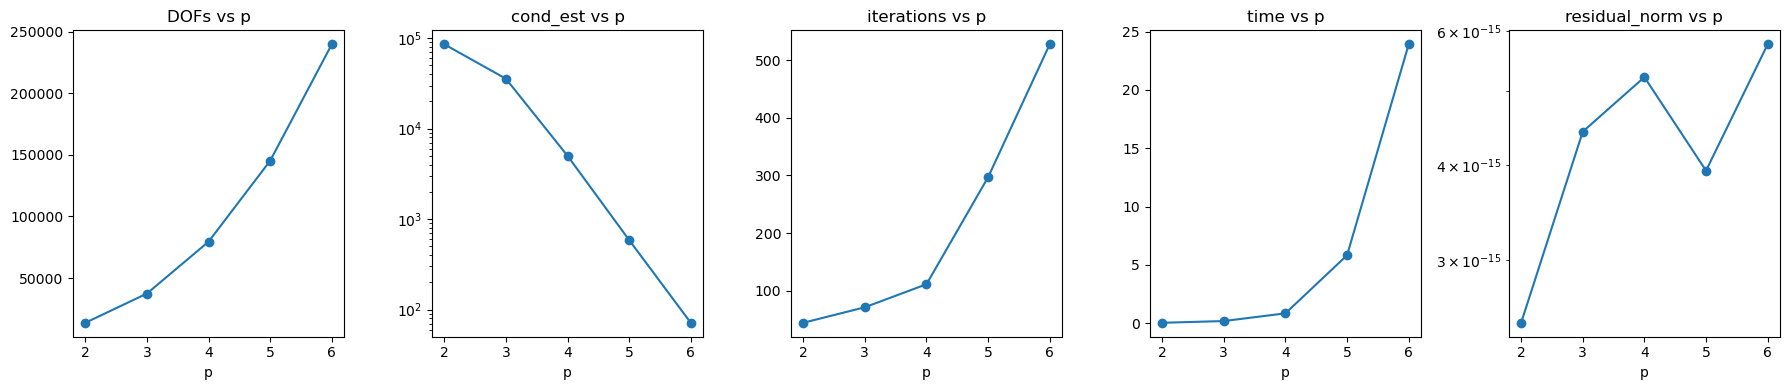

In [4]:
# Clear results
results = []

# Sweep polynomial order ; 5 and 6 need more power
p_list = [2, 3, 4, 5, 6]
for p in p_list:
    maxwell(p=p, hmax=2, M0=1000, eps=1e-8, nograds=True)

# Sammle Daten
dofs          = [r['dofs']          for r in results]
cond_est      = [r['cond']          for r in results]
iterations    = [r['iter']          for r in results]
times         = [r['time']          for r in results]
residual_norm = [r['residual_norm'] for r in results]

fig, axs = plt.subplots(1, 5, figsize=(18,4))
axs[0].plot(p_list, dofs, 'o-');           axs[0].set_title("DOFs vs p")
axs[1].plot(p_list, cond_est, 'o-');       axs[1].set_title("cond_est vs p");       axs[1].set_yscale("log")
axs[2].plot(p_list, iterations, 'o-');     axs[2].set_title("iterations vs p")
axs[3].plot(p_list, times, 'o-');          axs[3].set_title("time vs p")
axs[4].plot(p_list, residual_norm, 'o-');  axs[4].set_title("residual_norm vs p");  axs[4].set_yscale("log")
for i, lbl in enumerate(['p']*5):
    axs[i].set_xlabel(lbl)
plt.tight_layout(); plt.savefig("plot_p.pdf", bbox_inches='tight'); plt.show()

Running p=3, maxh=2, $M_0$=100, $arepsilon$=1e-08, nograds=True
2.5891945181217026e-15 72
Running p=3, maxh=2, $M_0$=200, $arepsilon$=1e-08, nograds=True
4.367304442894849e-15 71
Running p=3, maxh=2, $M_0$=500, $arepsilon$=1e-08, nograds=True
4.554637505979141e-15 71
Running p=3, maxh=2, $M_0$=1000, $arepsilon$=1e-08, nograds=True
4.419412335077534e-15 71


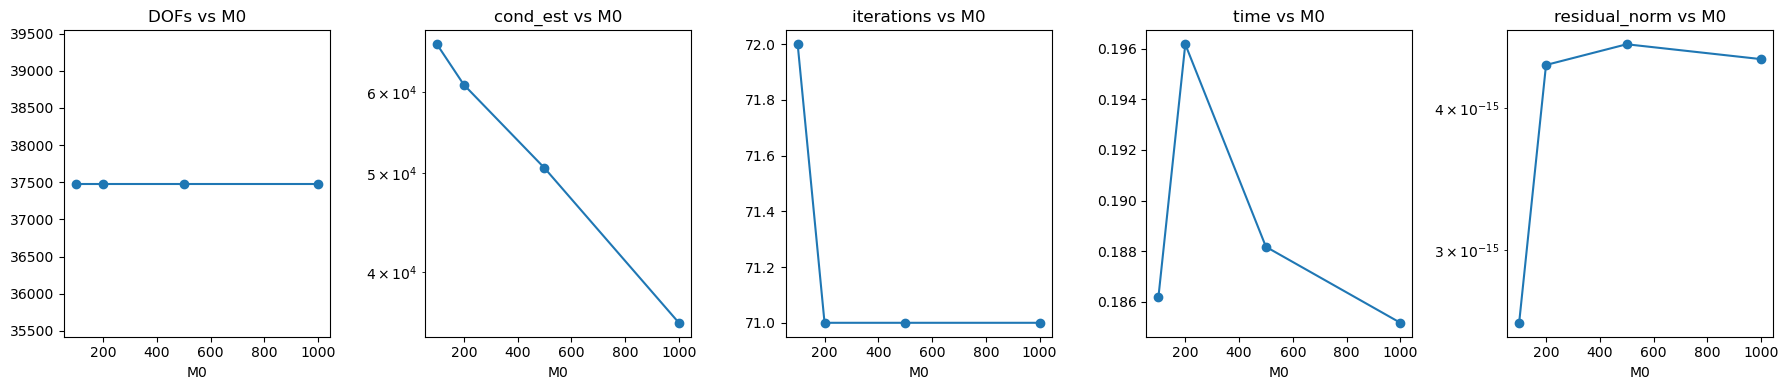

In [15]:
results = []
M0_list = [100, 200, 500, 1000]
for M0 in M0_list:
    maxwell(p=3, hmax=2, M0=M0, eps=1e-8, nograds=True)

dofs          = [r['dofs']          for r in results]
cond_est      = [r['cond']          for r in results]
iterations    = [r['iter']          for r in results]
times         = [r['time']          for r in results]
residual_norm = [r['residual_norm'] for r in results]

fig, axs = plt.subplots(1, 5, figsize=(18,4))
axs[0].plot(M0_list, dofs, 'o-');           axs[0].set_title("DOFs vs M0")
axs[1].plot(M0_list, cond_est, 'o-');       axs[1].set_title("cond_est vs M0");       axs[1].set_yscale("log")
axs[2].plot(M0_list, iterations, 'o-');     axs[2].set_title("iterations vs M0")
axs[3].plot(M0_list, times, 'o-');          axs[3].set_title("time vs M0")
axs[4].plot(M0_list, residual_norm, 'o-');  axs[4].set_title("residual_norm vs M0");  axs[4].set_yscale("log")
for i, lbl in enumerate(['M0']*5):
    axs[i].set_xlabel(lbl)
plt.tight_layout(); plt.savefig("plot_M.pdf", bbox_inches='tight'); plt.show()

Running p=3, maxh=0.25, $M_0$=1000, $arepsilon$=1e-08, nograds=True
3.832976314680801e-15 84
Running p=3, maxh=0.5, $M_0$=1000, $arepsilon$=1e-08, nograds=True
3.0448084956291857e-15 75
Running p=3, maxh=1, $M_0$=1000, $arepsilon$=1e-08, nograds=True
3.746616496550513e-15 71
Running p=3, maxh=2, $M_0$=1000, $arepsilon$=1e-08, nograds=True
4.423399824764104e-15 71
Running p=3, maxh=4, $M_0$=1000, $arepsilon$=1e-08, nograds=True
3.2183253130905464e-15 71


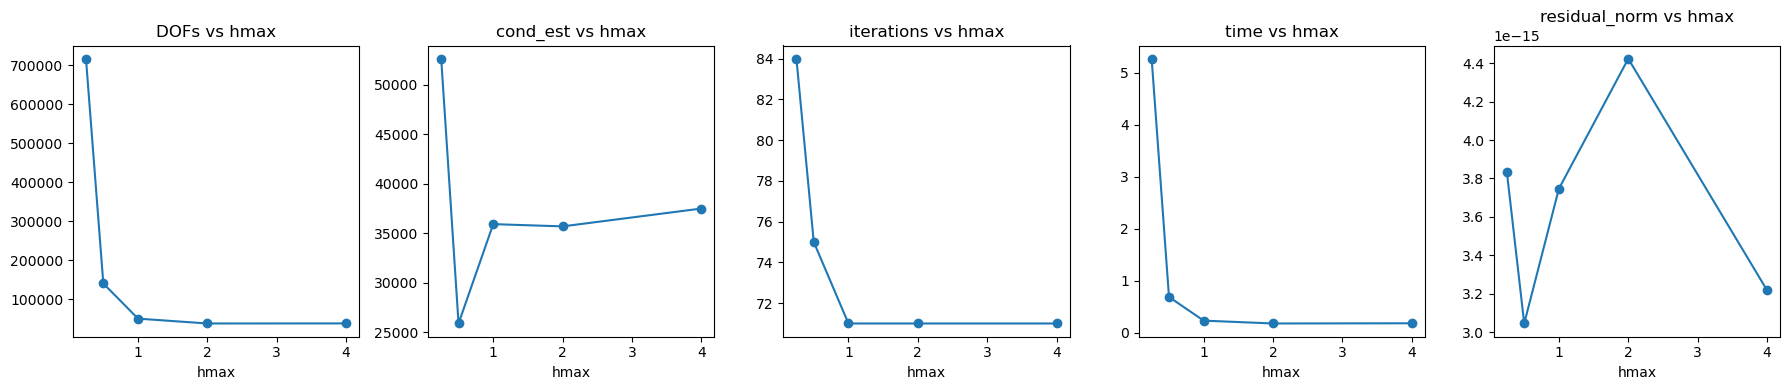

In [38]:
results = []
hmax_list = [0.25, 0.5, 1, 2, 4]
for hmax in hmax_list:
    maxwell(p=3, hmax=hmax, M0=1000, eps=1e-8, nograds=True)

dofs          = [r['dofs']          for r in results]
cond_est      = [r['cond']          for r in results]
iterations    = [r['iter']          for r in results]
times         = [r['time']          for r in results]
residual_norm = [r['residual_norm'] for r in results]

fig, axs = plt.subplots(1, 5, figsize=(18,4))
axs[0].plot(hmax_list, dofs, 'o-');           axs[0].set_title("DOFs vs hmax")#;       axs[1].set_yscale("log")
axs[1].plot(hmax_list, cond_est, 'o-');       axs[1].set_title("cond_est vs hmax")#;       axs[1].set_yscale("log")
axs[2].plot(hmax_list, iterations, 'o-');     axs[2].set_title("iterations vs hmax")#;       axs[1].set_yscale("log")
axs[3].plot(hmax_list, times, 'o-');          axs[3].set_title("time vs hmax")#;       axs[1].set_yscale("log")
axs[4].plot(hmax_list, residual_norm, 'o-');  axs[4].set_title("residual_norm vs hmax")#;  axs[4].set_yscale("log")
for i, lbl in enumerate(['hmax']*5):
    axs[i].set_xlabel(lbl)
plt.tight_layout(); plt.savefig("plot_hmax.pdf", bbox_inches='tight'); plt.show()

Running p=3, maxh=2, $M_0$=1000, $arepsilon$=1e-06, nograds=True
2.7751990662825864e-15 72
Running p=3, maxh=2, $M_0$=1000, $arepsilon$=1e-08, nograds=True
4.427570132263206e-15 71
Running p=3, maxh=2, $M_0$=1000, $arepsilon$=1e-10, nograds=True
4.6758154077608195e-15 71
Running p=3, maxh=2, $M_0$=1000, $arepsilon$=1e-12, nograds=True
1.987157414960884e-15 167


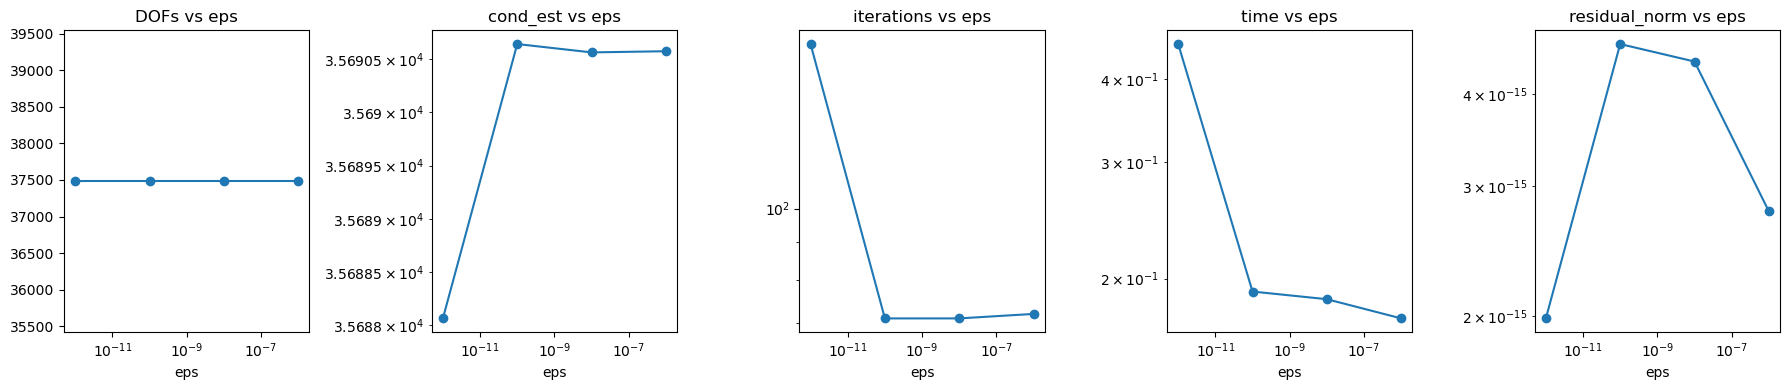

In [37]:
results = []
eps_list = [1e-6, 1e-8, 1e-10, 1e-12]
for eps in eps_list:
    maxwell(p=3, hmax=2, M0=1000, eps=eps, nograds=True)

dofs          = [r['dofs']          for r in results]
cond_est      = [r['cond']          for r in results]
iterations    = [r['iter']          for r in results]
times         = [r['time']          for r in results]
residual_norm = [r['residual_norm'] for r in results]

fig, axs = plt.subplots(1, 5, figsize=(18,4))
axs[0].plot(eps_list, dofs, 'o-');           axs[0].set_title("DOFs vs eps"); axs[0].set_xscale("log")
axs[1].plot(eps_list, cond_est, 'o-');       axs[1].set_title("cond_est vs eps"); axs[1].set_xscale("log"); axs[1].set_yscale("log")
axs[2].plot(eps_list, iterations, 'o-');     axs[2].set_title("iterations vs eps"); axs[2].set_xscale("log"); axs[2].set_yscale("log")
axs[3].plot(eps_list, times, 'o-');          axs[3].set_title("time vs eps"); axs[3].set_xscale("log"); axs[3].set_yscale("log")
axs[4].plot(eps_list, residual_norm, 'o-');  axs[4].set_title("residual_norm vs eps");  axs[4].set_xscale("log"); axs[4].set_yscale("log")
for i, lbl in enumerate(['eps']*5):
    axs[i].set_xlabel(lbl)
plt.xscale("log")
plt.tight_layout(); plt.savefig("plot_eps.pdf", bbox_inches='tight'); plt.show()

In [5]:
mesh, gfu = maxwell(p=4, hmax=2, M0=100, eps=1e-8, nograds=True)

Draw(curl(gfu), mesh, "B-field", draw_surf=False, \
      clipping = { "z" : -1, "function":True}, \
      vectors = { "grid_size":50}, min=0, max=2e-5);

Running p=4, maxh=2, $M_0$=100, $arepsilon$=1e-08, nograds=True
4.217892039641415e-15 111


WebGuiWidget(layout=Layout(height='50vh', width='100%'), value={'ngsolve_version': '6.2.2201', 'mesh_dim': 3, …

In [9]:
mesh, gfu = maxwell()

Draw(curl(gfu), mesh, "B-field", draw_surf=True,
     clipping = { "z" : -1, "function":True}, 
     vectors = { "grid_size":50}, min=0, max=2e-5);

Running p=3, maxh=2, $M_0$=1000, $arepsilon$=1e-08, nograds=True
4.417360366505291e-15 71


WebGuiWidget(layout=Layout(height='50vh', width='100%'), value={'ngsolve_version': '6.2.2201', 'mesh_dim': 3, …